https://www.newtraderu.com/2021/06/30/200-day-moving-average-vs-buy-and-hold/

https://github.com/hackingthemarkets/pyalgotrade-tutorials

http://gbeced.github.io/pyalgotrade/docs/v0.20/html/index.html

https://pypi.org/project/yfinance/

2003-02-28 00:00:00 strategy [INFO] buying at 21.845367431640625, which is above 21.830480794906787
2003-03-03 00:00:00 strategy [INFO] ===== BUY at 21.940876056198253 43487 =====
2004-04-30 00:00:00 strategy [INFO] selling at 30.201128005981445, which is below 30.424539442062557
2004-05-03 00:00:00 strategy [INFO] ===== SELL at 30.4009116583457 =====
2004-05-28 00:00:00 strategy [INFO] buying at 31.747243881225586, which is above 30.787104749679735
2004-06-01 00:00:00 strategy [INFO] ===== BUY at 31.504023227896077 40932 =====
2004-07-30 00:00:00 strategy [INFO] selling at 30.305362701416016, which is below 31.245721473694015
2004-08-02 00:00:00 strategy [INFO] ===== SELL at 30.062161164480784 =====
2004-10-29 00:00:00 strategy [INFO] buying at 32.05124282836914, which is above 31.061561002731473
2004-11-01 00:00:00 strategy [INFO] ===== BUY at 32.12073452068781 38795 =====
2005-04-29 00:00:00 strategy [INFO] selling at 30.674535751342773, which is below 31.986171245575107
2005-05-02 

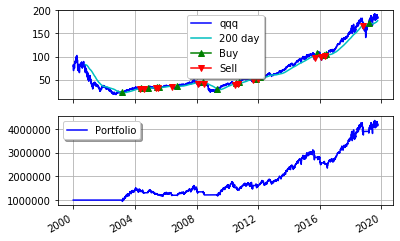

Final portfolio value: $4166390.53
Cumulative returns: 316.64 %
Max. drawdown: 27.23 %
Longest drawdown duration: 1338 days, 0:00:00

Total trades: 15
Avg. profit: $192927
Profits std. dev.: $452149
Max. profit: $1383102
Min. profit: $-226847
Avg. return: 12 %
Returns std. dev.: 25 %
Max. return: 75 %
Min. return: -10 %

Profitable trades: 7
Avg. profit: $506249
Profits std. dev.: $499474
Max. profit: $1383102
Min. profit: $16100
Avg. return: 32 %
Returns std. dev.: 25 %
Max. return: 75 %
Min. return:  1 %

Unprofitable trades: 8
Avg. loss: $-81230
Losses std. dev.: $63019
Max. loss: $-226847
Min. loss: $-17256
Avg. return: -5 %
Returns std. dev.:  3 %
Max. return: -1 %
Min. return: -10 %


In [6]:
import pandas
import pandas_market_calendars as market_calendar

# fonds="spy"
fonds="qqq"
# fonds="mt"
# fonds="bynd"
# fonds="asml"

from pyalgotrade import strategy
from pyalgotrade.barfeed import yahoofeed
from pyalgotrade.technical import ma
from pyalgotrade import plotter
from pyalgotrade.stratanalyzer import returns, drawdown, trades

# get last days of month
nyse = market_calendar.get_calendar('NYSE')
# df = nyse.schedule(start_date='2000-01-01', end_date='2021-12-31')
df = nyse.schedule(start_date='1997-01-01', end_date='2021-12-31')
df = df.groupby(df.index.strftime('%Y-%m')).tail(1)
df['date'] = pandas.to_datetime(df['market_open']).dt.date
last_days_of_month = [date.isoformat() for date in df['date'].tolist()]

class MovingAverageStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument):
        super(MovingAverageStrategy, self).__init__(feed)
        self.instrument = instrument
        self.position = None
        self.ma = ma.SMA(feed[instrument].getAdjCloseDataSeries(), 200)
        self.setUseAdjustedValues(True)

    def onEnterOk(self, position):
        execInfo = position.getEntryOrder().getExecutionInfo()
        self.info(f"===== BUY at {execInfo.getPrice()} {execInfo.getQuantity()} =====")

    def onExitOk(self, position):
        execInfo = position.getExitOrder().getExecutionInfo()
        self.info(f"===== SELL at {execInfo.getPrice()} =====")
        self.position = None
    
    def onBars(self, bars):
        if self.ma[-1] is None:
            return

        bar = bars[self.instrument]
        close = bar.getAdjClose()
        date = bar.getDateTime().date().isoformat()

        if date in last_days_of_month:
            if self.position is None:
                broker = self.getBroker()
                cash = broker.getCash() * .95
                
                if date in last_days_of_month and close > self.ma[-1]:
                    quantity = cash / close
                    self.info(f"buying at {close}, which is above {self.ma[-1]}")
                    self.position = self.enterLong(self.instrument, quantity)
            
            elif close < self.ma[-1] and self.position is not None:
                self.info(f"selling at {close}, which is below {self.ma[-1]}")
                self.position.exitMarket()
                self.position = None


# # Load the bar feed from the CSV file
feed = yahoofeed.Feed()
# feed.addBarsFromCSV("spy", "spy.csv")
feed.addBarsFromCSV(fonds, fonds + ".csv")

# strategy = MovingAverageStrategy(feed, "spy")
strategy = MovingAverageStrategy(feed, fonds)

returnsAnalyzer = returns.Returns()
tradesAnalyzer = trades.Trades()
drawDownAnalyzer = drawdown.DrawDown()

strategy.attachAnalyzer(returnsAnalyzer)
strategy.attachAnalyzer(drawDownAnalyzer)
strategy.attachAnalyzer(tradesAnalyzer)

plt = plotter.StrategyPlotter(strategy) 
# plt.getInstrumentSubplot("spy").addDataSeries("200 day", strategy.ma)
plt.getInstrumentSubplot(fonds).addDataSeries("200 day", strategy.ma)

strategy.run()

plt.plot()

print("Final portfolio value: $%.2f" % strategy.getResult())
print("Cumulative returns: %.2f %%" % (returnsAnalyzer.getCumulativeReturns()[-1] * 100))
print("Max. drawdown: %.2f %%" % (drawDownAnalyzer.getMaxDrawDown() * 100))
print("Longest drawdown duration: %s" % (drawDownAnalyzer.getLongestDrawDownDuration()))

print("")
print("Total trades: %d" % (tradesAnalyzer.getCount()))
if tradesAnalyzer.getCount() > 0:
    profits = tradesAnalyzer.getAll()
    print("Avg. profit: $%2.f" % (profits.mean()))
    print("Profits std. dev.: $%2.f" % (profits.std()))
    print("Max. profit: $%2.f" % (profits.max()))
    print("Min. profit: $%2.f" % (profits.min()))
    returns = tradesAnalyzer.getAllReturns()
    print("Avg. return: %2.f %%" % (returns.mean() * 100))
    print("Returns std. dev.: %2.f %%" % (returns.std() * 100))
    print("Max. return: %2.f %%" % (returns.max() * 100))
    print("Min. return: %2.f %%" % (returns.min() * 100))

print("")
print("Profitable trades: %d" % (tradesAnalyzer.getProfitableCount()))
if tradesAnalyzer.getProfitableCount() > 0:
    profits = tradesAnalyzer.getProfits()
    print("Avg. profit: $%2.f" % (profits.mean()))
    print("Profits std. dev.: $%2.f" % (profits.std()))
    print("Max. profit: $%2.f" % (profits.max()))
    print("Min. profit: $%2.f" % (profits.min()))
    returns = tradesAnalyzer.getPositiveReturns()
    print("Avg. return: %2.f %%" % (returns.mean() * 100))
    print("Returns std. dev.: %2.f %%" % (returns.std() * 100))
    print("Max. return: %2.f %%" % (returns.max() * 100))
    print("Min. return: %2.f %%" % (returns.min() * 100))

print("")
print("Unprofitable trades: %d" % (tradesAnalyzer.getUnprofitableCount()))
if tradesAnalyzer.getUnprofitableCount() > 0:
    losses = tradesAnalyzer.getLosses()
    print("Avg. loss: $%2.f" % (losses.mean()))
    print("Losses std. dev.: $%2.f" % (losses.std()))
    print("Max. loss: $%2.f" % (losses.min()))
    print("Min. loss: $%2.f" % (losses.max()))
    returns = tradesAnalyzer.getNegativeReturns()
    print("Avg. return: %2.f %%" % (returns.mean() * 100))
    print("Returns std. dev.: %2.f %%" % (returns.std() * 100))
    print("Max. return: %2.f %%" % (returns.max() * 100))
    print("Min. return: %2.f %%" % (returns.min() * 100))
